# **CAPSTONE PROJECT - WEB AND SOCIAL MEDIA ANALYTICS**

## **Problem Statement**

Let's say your client is a US-based mobile device maker that only recently joined the market. Being a newcomer to the market, they wish to comprehend their rivals and the preferences of their customers in order to tailor their plans. To strengthen their brand, give customers features that are most valuable, and reduce the supply-demand imbalance, they wish to make adjustments to their marketing methods. Their goal is to boost both their brand's value and market share.

Assume that this mobile phone manufacturer has contacted you as a data analytics supplier. To assist them in achieving their goal, they want you to give them some important insights into the mobile phone sector.Their objective is to develop a new product optimally and create some marketing strategies.

**Mounting Google Drive with Colab**

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Checking the files in Google drive under Web_and_social_media_analytics folder**

In [103]:
!ls drive/'MyDrive/Web_and_social_media_analytics'/

'Brands and Asins.csv'			    phone_data_final.csv
 Cell_Phones_and_Accessories_5.csv	    phone_reviews.csv
 meta_Cell_Phones_and_Accessories.json	    positive_corpus.xlsx
 meta_Cell_Phones_and_Accessories.json.gz   pos_words.txt
 negative_corpus.xlsx			    review_sentiment.csv
 neg_words.txt				    stop_words_long.txt


### **Importing Libraries**

In [104]:
import pandas as pd
import numpy as np
import gzip
import shutil
import json
from datetime import datetime, timedelta
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
import re
import string
from nltk import word_tokenize, bigrams, FreqDist
from sklearn.model_selection  import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import networkx as nx

In [105]:
#importing necessary visualisation libraries
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

###**Reading the Data**

1. Phone data as the .csv file: Contains the consumer activity information
2. Phone metadata as zipped .json file: This data contains the product information and is independent of the consumer/reviewer activity and includes description, price, sales-rank, brand info, and co-purchasing links etc.

In [106]:
#Path to the meta data zip file 'meta_cell_phones_and_Accessories' is the folder name under 'My Drive/Web_and_social_media_analytics'
path1 = '/content/drive/MyDrive/Web_and_social_media_analytics/meta_Cell_Phones_and_Accessories.json.gz'

# Path to meta data .json file
path2 = '/content/drive/MyDrive/meta_Cell_Phones_and_Accessories.json'

# Unzipping the meta data file
with gzip.open(path1, 'rb') as f_in:
    with open(path2, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [107]:
# Reading the unzipped meta data into a Python list. The result will be a list of dictionaries.

phonemetadata = []

# Reading the dictionaries in the json file and appending it to the list phonemetadata[]
with open(path2, 'r') as file:
    for line in file:
        phonemetadata.append(json.loads(line))

In [108]:
# Number of entries in the phonemetadata list
len(phonemetadata)

590071

In [109]:
#Converting the list phonemetadata into a data frame
meta=pd.DataFrame(phonemetadata)

#Creating new .csv file for meta
meta.to_csv('/content/drive/MyDrive/meta.csv', escapechar='\\')

In [110]:
#reading meta.csv file
meta=pd.read_csv('/content/drive/MyDrive/meta.csv')

<ipython-input-110-d5c9e9542def>:2: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  meta=pd.read_csv('/content/drive/MyDrive/meta.csv')


In [111]:
#Reading the .csv file of the phone data into a dataframe

phonedata = pd.read_csv('/content/drive/MyDrive/Web_and_social_media_analytics/Cell_Phones_and_Accessories_5.csv')

<ipython-input-111-bddf93f219e0>:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  phonedata = pd.read_csv('/content/drive/MyDrive/Web_and_social_media_analytics/Cell_Phones_and_Accessories_5.csv')


In [112]:
phonedata.head(5)

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,review_sentiment
0,5.0,True,A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN,POSITIVE
1,5.0,True,A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN,POSITIVE
2,3.0,True,AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN,NEGATIVE
3,2.0,True,A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000,NaN,NaN,POSITIVE
4,4.0,True,A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600,NaN,NaN,POSITIVE


### **Data Pre-Processing**

In [113]:
#Transforming unixReview time to date time format in phone data
phonedata['DateTime'] = phonedata['unixReviewTime'].apply(lambda d: (datetime.fromtimestamp(d) - timedelta(hours=2)).strftime('%d-%m-%Y'))

In [114]:
phonedata.head(5)

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,review_sentiment,DateTime
0,5.0,True,A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN,POSITIVE,03-08-2014
1,5.0,True,A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN,POSITIVE,11-02-2014
2,3.0,True,AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN,NEGATIVE,07-02-2014
3,2.0,True,A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000,NaN,NaN,POSITIVE,03-02-2014
4,4.0,True,A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600,NaN,NaN,POSITIVE,02-02-2014


In [115]:
#Shape of phonedata
phonedata.shape

(1128437, 13)

In [116]:
#Checking phonedata info
phonedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   overall           1128437 non-null  float64
 1   verified          1128437 non-null  bool   
 2   reviewerID        1128437 non-null  object 
 3   asin              1128437 non-null  object 
 4   style             605241 non-null   object 
 5   reviewerName      1128281 non-null  object 
 6   reviewText        1127669 non-null  object 
 7   summary           1127912 non-null  object 
 8   unixReviewTime    1128437 non-null  int64  
 9   vote              92034 non-null    object 
 10  image             27107 non-null    object 
 11  review_sentiment  1128437 non-null  object 
 12  DateTime          1128437 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 104.4+ MB


In [117]:
#Checking null values in phonedata
phonedata.isnull().sum()

overall                   0
verified                  0
reviewerID                0
asin                      0
style                523196
reviewerName            156
reviewText              768
summary                 525
unixReviewTime            0
vote                1036403
image               1101330
review_sentiment          0
DateTime                  0
dtype: int64

In [118]:
#Dropping columns which have extreme number of null values. Also dropping unixReviewTime
phonedata.drop(['vote','image','unixReviewTime'], axis = 1, inplace = True)

In [119]:
#Deleting rows where style is null
phonedata=phonedata[~phonedata['style'].isnull()]

In [120]:
phonedata.isnull().sum()

overall               0
verified              0
reviewerID            0
asin                  0
style                 0
reviewerName         80
reviewText          435
summary             322
review_sentiment      0
DateTime              0
dtype: int64

In [121]:
#Checking current shape of phonedata
phonedata.shape

(605241, 10)

In [122]:
#Describing phonedata
phonedata.describe()

,overall
count,605241.000000
mean,4.257537
std,1.198782
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [123]:
meta.head(5)

,Unnamed: 0,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,0,"['Cell Phones & Accessories', 'Accessories', '...",NaN,[],NaN,Trollies Sing a Long Party VHS,[],[],NaN,NaN,[],"557,379 in Movies & TV (",[],{'ASIN: ': '6303195164'},Movies & TV,NaN,NaN,NaN,6303195164
1,1,"['Cell Phones & Accessories', 'Accessories', '...",NaN,[],NaN,La Pura VHS,[],[],NaN,Maribel Guardia,[],"1,024,449 in Movies & TV (",[],{'ASIN: ': '630524412X'},Movies & TV,NaN,NaN,NaN,630524412X
2,2,"['Cell Phones & Accessories', 'Cases, Holsters...",NaN,"['New items to give you a new good mood, welco...",NaN,Leopard Thanksgiving Easter PC Black Case for ...,[],[],NaN,NaN,[],"5,315,017 in Books (",[],"{'Publisher:': 'juduiou', 'ASIN:': '6310200240...",Books,NaN,NaN,NaN,6310200240
3,3,"['Cell Phones & Accessories', 'Cases, Holsters...",NaN,"['A brand-new, unused, unopened, undamaged ite...",NaN,Puppies Faceplate Hard Case Protector for Net1...,[],[],NaN,Live2Pedal,['Protect your phone with style through this A...,"['>#6,368,825 in Cell Phones & Accessories (Se...",[],{},Cell Phones & Accessories,NaN,NaN,NaN,6786501710
4,4,"['Cell Phones & Accessories', 'Cases, Holsters...",NaN,"['A brand-new, unused, unopened, undamaged ite...",NaN,White Wolf Faceplate Protector Hard Case for S...,[],[],NaN,wirelessoutletusa,['Protect your phone with style through this A...,"['>#2,672,454 in Cell Phones & Accessories (Se...",[],{},Cell Phones & Accessories,NaN,NaN,NaN,6786501273


In [124]:
#Checking meta info
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590071 entries, 0 to 590070
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    590071 non-null  int64 
 1   category      590071 non-null  object
 2   tech1         6585 non-null    object
 3   description   590071 non-null  object
 4   fit           43 non-null      object
 5   title         590062 non-null  object
 6   also_buy      590071 non-null  object
 7   image         590071 non-null  object
 8   tech2         231 non-null     object
 9   brand         577311 non-null  object
 10  feature       590071 non-null  object
 11  rank          590071 non-null  object
 12  also_view     590071 non-null  object
 13  details       590071 non-null  object
 14  main_cat      586685 non-null  object
 15  similar_item  50931 non-null   object
 16  date          45880 non-null   object
 17  price         127564 non-null  object
 18  asin          590071 non

In [125]:
#Checking meta shape
meta.shape

(590071, 19)

In [126]:
#Describing meta
meta.describe()

,Unnamed: 0
count,590071.000000
mean,295035.000000
std,170338.969683
min,0.000000
25%,147517.500000
50%,295035.000000
75%,442552.500000
max,590070.000000


In [127]:
#Checking null values in meta
meta.isnull().sum()

Unnamed: 0           0
category             0
tech1           583486
description          0
fit             590028
title                9
also_buy             0
image                0
tech2           589840
brand            12760
feature              0
rank                 0
also_view            0
details              0
main_cat          3386
similar_item    539140
date            544191
price           462507
asin                 0
dtype: int64

In [128]:
#Dropping columns with extremely high null values
meta.drop(['tech1','tech2','fit','date'], axis = 1, inplace = True)

In [129]:
#Dropping duplicates in ASIN
meta.drop_duplicates(subset='asin',inplace=True)

In [130]:
#Deleting rows where brand is null
meta=meta[~meta['brand'].isna()]

In [131]:
#Impute null where price having descriptive text
meta['price']=[np.nan if len(str(x))>15 else x for x in meta['price']]

In [132]:
#Deleting rows where price is null
meta=meta[~meta['price'].isna()]

In [133]:
#Deleting rows where similar_item is null
meta=meta[~meta['similar_item'].isna()]

In [134]:
meta.isnull().sum()

Unnamed: 0       0
category         0
description      0
title            0
also_buy         0
image            0
brand            0
feature          0
rank             0
also_view        0
details          0
main_cat        37
similar_item     0
price            0
asin             0
dtype: int64

In [135]:
#Dropping rows where catogory doesn't have Cell Phone
substring_to_search = "\'Cell Phones\'"
meta = meta[meta['category'].str.contains(substring_to_search, case=False, na=False)]
#meta['category'] = meta['category'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)

In [136]:
meta.shape

(1305, 15)

In [137]:
meta.head(5)

,Unnamed: 0,category,description,title,also_buy,image,brand,feature,rank,also_view,details,main_cat,similar_item,price,asin
4018,4018,"['Cell Phones & Accessories', 'Cell Phones', '...",['The Nokia 1100 phone lets you conduct busine...,Unlocked Nokia 1100,"['B00095MR5W', 'B00R25GJJW']",['https://images-na.ssl-images-amazon.com/imag...,Nokia,['Unlocked Nokia 1100'],"['>#510,212 in Cell Phones & Accessories (See ...","['B075FL4H89', 'B0757B64H2', 'B0757BT4C8', 'B0...",{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",$40.08,B000FJ1XWA
4130,4130,"['Cell Phones & Accessories', 'Cell Phones', '...",['Like new in box great looking phone get it b...,Motorola Moto Q - Smartphone - CDMA2000 1X - b...,[],['https://images-na.ssl-images-amazon.com/imag...,Motorola,[],"['>#503,104 in Cell Phones & Accessories (See ...","['B014VM1CYU', 'B00O5EU7TQ', 'B00NSRC4Y2', 'B0...",{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",$17.99,B000FYU4SO
4148,4148,"['Cell Phones & Accessories', 'Cell Phones', '...",['The sleek VX8300 is built for serious mobile...,Verizon or PagePlus LG VX8300 Great Condition ...,"['B000HHIUOE', 'B0021KAD3Q', 'B000SCGYKK', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,LG,['This product has been carefully audited and ...,"['>#149,915 in Cell Phones & Accessories (See ...",[],{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",$27.57,B000G2TLIO
4170,4170,"['Cell Phones & Accessories', 'Cell Phones', '...","[""The Moto Razr V3 is expertly crafted to deli...","Motorola RAZR V3 Unlocked Phone with Camera, V...",[],['https://images-na.ssl-images-amazon.com/imag...,Motorola,['This unlocked cell phone is compatible with ...,"['>#335,739 in Cell Phones & Accessories (See ...","['B0009FCAJA', 'B0016JDBYG', 'B002UHS0UI', 'B0...",{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",$105.99,B000G7LZCO
5767,5767,"['Cell Phones & Accessories', 'Cell Phones', '...",['GSM/EDGE coverage (900/1800/1900 MHz))\\n\\n...,Nokia 6300 Unlocked Triband Camera Business Phone,['B002LSHZPM'],['https://images-na.ssl-images-amazon.com/imag...,Nokia,['Nokia 6300 - Silver black (Unlocked) Mobile ...,"['>#456,762 in Cell Phones & Accessories (See ...","['B075FL4H89', 'B0757B64H2', 'B0172EEAQQ', 'B0...",{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",$40.08,B000MXF2IK


In [138]:
#Replace $ to none and convert price to float
meta['price']= meta['price'].str.replace("$",'')
meta['price']= meta['price'].str.replace(",",'')
meta['price']= pd.to_numeric(meta['price'], errors='coerce')

<ipython-input-138-09613ebc1d19>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  meta['price']= meta['price'].str.replace("$",'')
<ipython-input-138-09613ebc1d19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['price']= meta['price'].str.replace("$",'')
<ipython-input-138-09613ebc1d19>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['pric

In [139]:
#Extracting rank in cellphones and acessories
meta['rank']=meta['rank'].str.extract(pat='([^>#](\d{0,3},)?(\d{3},)?\d{0,3}\s*in Cell Phones & Accessories)')[0]
meta['rank']=meta['rank'].str.replace(">#","").str.replace("in Cell Phones & Accessories","").str.replace(",","")
meta['rank'] = meta['rank'].astype("float")

<ipython-input-139-b225a51e4c47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['rank']=meta['rank'].str.extract(pat='([^>#](\d{0,3},)?(\d{3},)?\d{0,3}\s*in Cell Phones & Accessories)')[0]
<ipython-input-139-b225a51e4c47>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['rank']=meta['rank'].str.replace(">#","").str.replace("in Cell Phones & Accessories","").str.replace(",","")
<ipython-input-139-b225a51e4c47>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [140]:
#creating new .csv file for cleaned meta
meta.to_csv('/content/drive/MyDrive/metadata.csv')

In [141]:
#reading metadata.csv file
metadata=pd.read_csv('/content/drive/MyDrive/metadata.csv')

In [142]:
metadata.head(5)

,Unnamed: 0.1,Unnamed: 0,category,description,title,also_buy,image,brand,feature,rank,also_view,details,main_cat,similar_item,price,asin
0,4018,4018,"['Cell Phones & Accessories', 'Cell Phones', '...",['The Nokia 1100 phone lets you conduct busine...,Unlocked Nokia 1100,"['B00095MR5W', 'B00R25GJJW']",['https://images-na.ssl-images-amazon.com/imag...,Nokia,['Unlocked Nokia 1100'],510212.0,"['B075FL4H89', 'B0757B64H2', 'B0757BT4C8', 'B0...",{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",40.08,B000FJ1XWA
1,4130,4130,"['Cell Phones & Accessories', 'Cell Phones', '...",['Like new in box great looking phone get it b...,Motorola Moto Q - Smartphone - CDMA2000 1X - b...,[],['https://images-na.ssl-images-amazon.com/imag...,Motorola,[],503104.0,"['B014VM1CYU', 'B00O5EU7TQ', 'B00NSRC4Y2', 'B0...",{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",17.99,B000FYU4SO
2,4148,4148,"['Cell Phones & Accessories', 'Cell Phones', '...",['The sleek VX8300 is built for serious mobile...,Verizon or PagePlus LG VX8300 Great Condition ...,"['B000HHIUOE', 'B0021KAD3Q', 'B000SCGYKK', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,LG,['This product has been carefully audited and ...,149915.0,[],{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",27.57,B000G2TLIO
3,4170,4170,"['Cell Phones & Accessories', 'Cell Phones', '...","[""The Moto Razr V3 is expertly crafted to deli...","Motorola RAZR V3 Unlocked Phone with Camera, V...",[],['https://images-na.ssl-images-amazon.com/imag...,Motorola,['This unlocked cell phone is compatible with ...,335739.0,"['B0009FCAJA', 'B0016JDBYG', 'B002UHS0UI', 'B0...",{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",105.99,B000G7LZCO
4,5767,5767,"['Cell Phones & Accessories', 'Cell Phones', '...",['GSM/EDGE coverage (900/1800/1900 MHz))\\n\\n...,Nokia 6300 Unlocked Triband Camera Business Phone,['B002LSHZPM'],['https://images-na.ssl-images-amazon.com/imag...,Nokia,['Nokia 6300 - Silver black (Unlocked) Mobile ...,456762.0,"['B075FL4H89', 'B0757B64H2', 'B0172EEAQQ', 'B0...",{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",40.08,B000MXF2IK


In [143]:
#Merging phonedata and metadata using asin
df = pd.merge(phonedata, metadata, how="inner", on=["asin"])

In [144]:
df.head(5)

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,review_sentiment,DateTime,...,also_buy,image,brand,feature,rank,also_view,details,main_cat,similar_item,price
0,4.0,False,A1ICOB5XZ9GK3R,B002KQLUVU,{'Color:': ' Black'},pinknblu,"I gave it a four because when I first got it, ...",Blackberry Rim 8520,POSITIVE,06-09-2009,...,"['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",16.0
1,5.0,True,A2O0XNK7T4KASU,B002KQLUVU,{'Color:': ' Black'},JR,Good,Good,POSITIVE,17-08-2017,...,"['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",16.0
2,5.0,True,A3CB1J66JA929L,B002KQLUVU,{'Color:': ' Black'},Idelfonzo,ok,Five Stars,POSITIVE,14-07-2017,...,"['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",16.0
3,5.0,True,A1H8OJ4PPV9R12,B002KQLUVU,{'Color:': ' Black'},Daniel Garanton.,Excelente!,Five Stars,NEGATIVE,16-02-2017,...,"['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",16.0
4,1.0,True,A2H6U09YBWFYPJ,B002KQLUVU,{'Color:': ' Black'},Donysius R.,unhappy with the product ... is not what I wan...,One Star,NEGATIVE,24-12-2016,...,"['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",16.0


In [145]:
#creating new .csv for merged data
df.to_csv('/content/drive/MyDrive/finaldata.csv')

In [146]:
pip install xlsxwriter

### **Text Analytics**

In [147]:
# Changes the overall category to categorical from numerical for easier visualizations
df["overall_rating"] = df["overall"]
df["overall_rating"].replace({5.0: "positive",4.0:"positive",3.0:"neutral",2.0:"negative",1.0:"negative"}, inplace=True)
df["overall_rating"].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [148]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [149]:
# Reading stop words from a text file in to a list
stop_words = [line.rstrip('\n') for line in open('/content/drive/My Drive/Web_and_social_media_analytics/stop_words_long.txt')]

In [150]:
# splits review rating into different classes, say positive = 1 and negative = 0.
def classify(x):
    if x == 'POSITIVE':
        return 1
    return 0

In [151]:
#Creating new column with corresponding class labels, the output variable.
df['y'] = df['review_sentiment'].apply(classify)

In [152]:
df.head(2)

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,review_sentiment,DateTime,...,brand,feature,rank,also_view,details,main_cat,similar_item,price,overall_rating,y
0,4.0,False,A1ICOB5XZ9GK3R,B002KQLUVU,{'Color:': ' Black'},pinknblu,"I gave it a four because when I first got it, ...",Blackberry Rim 8520,POSITIVE,06-09-2009,...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",16.0,positive,1
1,5.0,True,A2O0XNK7T4KASU,B002KQLUVU,{'Color:': ' Black'},JR,Good,Good,POSITIVE,17-08-2017,...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},Cell Phones & Accessories,"class=""a-bordered a-horizontal-stripes a-spa...",16.0,positive,1


In [153]:
#Dropping all NaN values from the column reviewText
df = df.dropna(axis=0, subset=['reviewText'])

In [154]:
df.isnull().sum()

overall              0
verified             0
reviewerID           0
asin                 0
style                0
reviewerName         2
reviewText           0
summary              5
review_sentiment     0
DateTime             0
Unnamed: 0.1         0
Unnamed: 0           0
category             0
description          0
title                0
also_buy             0
image                0
brand                0
feature              0
rank                24
also_view            0
details              0
main_cat             0
similar_item         0
price                0
overall_rating       0
y                    0
dtype: int64

In [155]:
#Dropping uneccesary columns for the analysis
df = df.drop(labels=['Unnamed: 0','Unnamed: 0.1','verified','asin' ,'style','reviewerName','description','title', 'main_cat' ],axis=1)

In [156]:
#Removes all the punctuations for the strings of reviewText, ie '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punctuation(text):
    no_punctuation=[words for words in text if words not in string.punctuation]
    without_punct=''.join(no_punctuation)
    return without_punct

In [157]:
#Removing all the punctuations from the words, and changing the words to lower case to maintain uniformity
df['reviewText']=df['reviewText'].apply(lambda x: remove_punctuation(x.lower()))

In [158]:
#Stemming
stemmer = PorterStemmer()

In [159]:
#Removing stop words from review
words = stopwords.words("english")
df['clean_reviews'] = df['reviewText'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [160]:
#Dropping null values in the cleaned dataset
df = df.dropna(subset=['clean_reviews'])

In [161]:
#Excel file for final tableau analysis
df.to_excel("/content/drive/MyDrive/final_for_tableau.xlsx", engine='xlsxwriter')

In [162]:
df.head(5)

,overall,reviewerID,reviewText,summary,review_sentiment,DateTime,category,also_buy,image,brand,feature,rank,also_view,details,similar_item,price,overall_rating,y,clean_reviews
0,4.0,A1ICOB5XZ9GK3R,i gave it a four because when i first got it i...,Blackberry Rim 8520,POSITIVE,06-09-2009,"['Cell Phones & Accessories', 'Cell Phones', '...","['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},"class=""a-bordered a-horizontal-stripes a-spa...",16.0,positive,1,gave four first got took time see get use key ...
1,5.0,A2O0XNK7T4KASU,good,Good,POSITIVE,17-08-2017,"['Cell Phones & Accessories', 'Cell Phones', '...","['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},"class=""a-bordered a-horizontal-stripes a-spa...",16.0,positive,1,good
2,5.0,A3CB1J66JA929L,ok,Five Stars,POSITIVE,14-07-2017,"['Cell Phones & Accessories', 'Cell Phones', '...","['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},"class=""a-bordered a-horizontal-stripes a-spa...",16.0,positive,1,ok
3,5.0,A1H8OJ4PPV9R12,excelente,Five Stars,NEGATIVE,16-02-2017,"['Cell Phones & Accessories', 'Cell Phones', '...","['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},"class=""a-bordered a-horizontal-stripes a-spa...",16.0,positive,0,excelent
4,1.0,A2H6U09YBWFYPJ,unhappy with the product is not what i want a...,One Star,NEGATIVE,24-12-2016,"['Cell Phones & Accessories', 'Cell Phones', '...","['B004G8QNDA', 'B002LDHF2K', 'B0085EIE38', 'B0...",['https://images-na.ssl-images-amazon.com/imag...,BlackBerry,"['2.0MP Digital Camera, High-resolution displa...",228047.0,[],{},"class=""a-bordered a-horizontal-stripes a-spa...",16.0,negative,0,unhappi product want read amazon


### **Visualization**

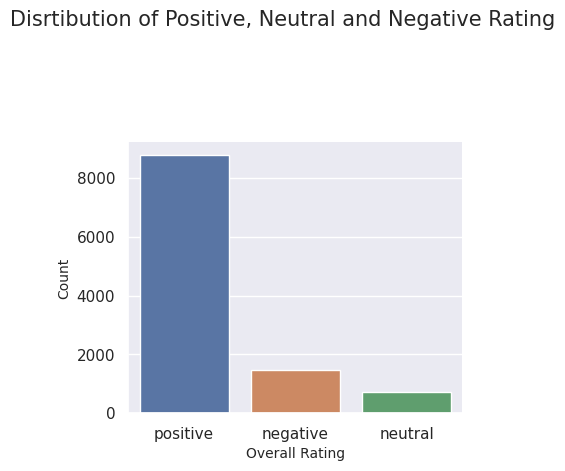

In [163]:
#Distribution of sentiment across the dataset using classes column
fig, axes = plt.subplots(1, figsize=(5,5))
fig.suptitle("Disrtibution of Positive, Neutral and Negative Rating", fontsize = 15)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "overall_rating", data = df)
axes.set_xlabel("Overall Rating", fontsize = 10)
axes.set_ylabel("Count", fontsize = 10)
sns.despine()

In [164]:
#Calculate the percentage for each value
percentage_values = (df['overall_rating'].value_counts() / len(df)) * 100
percentage_values = percentage_values.round(2)

In [165]:
print(percentage_values)

positive    80.01
negative    13.54
neutral      6.46
Name: overall_rating, dtype: float64


In [166]:
#Top 7 brand having more count of reviews
df['brand'].value_counts()[:7]

Samsung       4735
LG            1239
BlackBerry    1057
Motorola       770
BLU            619
Huawei         583
HTC            434
Name: brand, dtype: int64

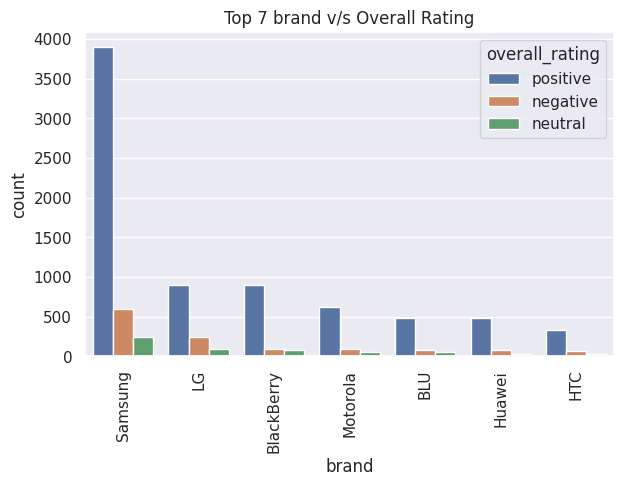

In [167]:
#Visualizing Top brands and reviews
plt.figure()
sns.countplot(data=df,x=df['brand'],hue=df['overall_rating'],order=df['brand'].value_counts().iloc[:7].index)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("Top 7 brand v/s Overall Rating")
plt.show()

In [168]:
df['price'].dtype

dtype('float64')

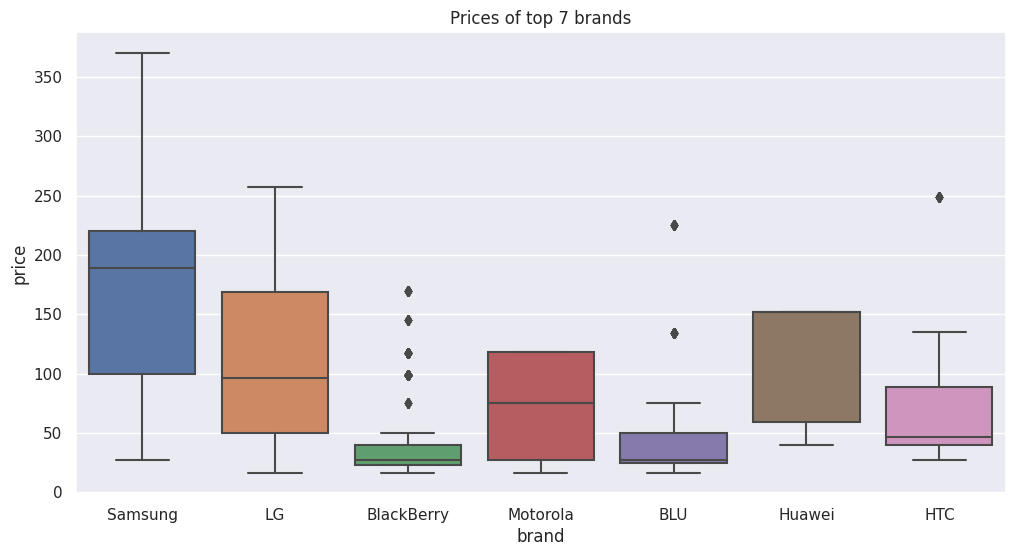

In [169]:
#Prices of Top 7 brands
plt.figure(figsize=[12,6])
plt.title("Prices of top 7 brands")
sns.boxplot(data=df,x='brand',y='price',order=df['brand'].value_counts().iloc[:7].index)
plt.show()

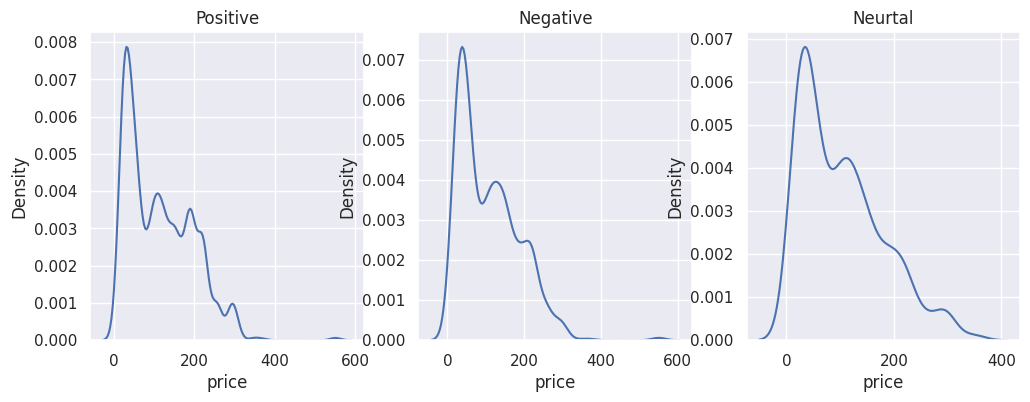

In [170]:
#Price v/s Overall Rating
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 3, 1, title="Positive")
ax2 = fig.add_subplot(1, 3, 2, title="Negative")
ax3 = fig.add_subplot(1, 3, 3, title="Neurtal")
sns.kdeplot(df[df['overall_rating'] == "positive"]['price'], ax=ax1)
sns.kdeplot(df[df['overall_rating'] == "negative"]['price'], ax=ax2)
sns.kdeplot(df[df['overall_rating'] == "neutral"]['price'], ax=ax3)
plt.show()

In [171]:
# Most repeated words in reviews
stopwords = set(STOPWORDS)
def word_cloud(data, title):
    wordcloud = WordCloud(
    background_color = "white",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords,
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (6, 6))
    plt.axis("on")
    if title:
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.35)
    plt.imshow(wordcloud)
    plt.show()

In [172]:
# seperating all records into a different variable to generate wordcloud based on overall rating
neg=df[df['overall_rating'] == "negative"]['clean_reviews']
pos=df[df['overall_rating'] == "positive"]['clean_reviews']
neu=df[df['overall_rating'] == "neutral"]['clean_reviews']

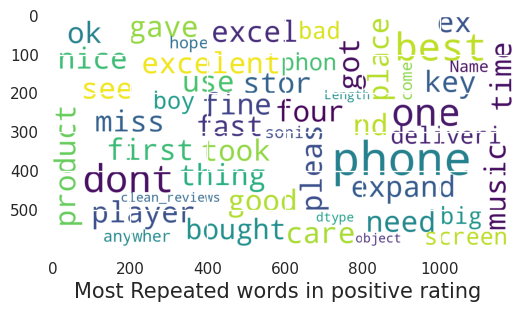

In [173]:
word_cloud(pos, "Most Repeated words in positive rating")

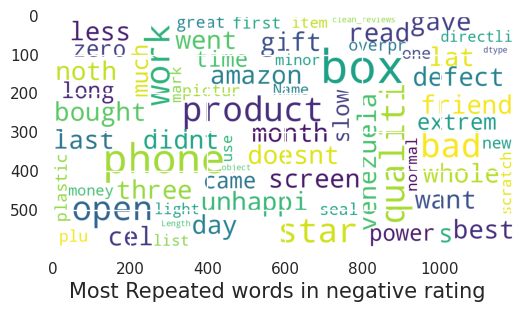

In [174]:
word_cloud(neg, "Most Repeated words in negative rating")

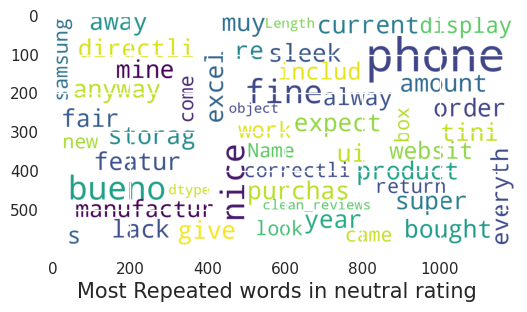

In [175]:
word_cloud(neu, "Most Repeated words in neutral rating")

### **Model Building**

In [176]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [177]:
def preprocessText(document):
     # tokenize into words
         # change sentence to lower case
    document = document.lower()
    words = word_tokenize(document)

    # remove stop words
    words = [word for word in words if word not in stop_words]

    #apply lemmatization
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

    words=[word for word in words if len(word)>2]
    # join words to make sentence
    document = " ".join(words)

    return document

In [178]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
df['clean_reviews']=[preprocessText(str(x)) for x in df['clean_reviews']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [179]:
#Creating X and y
X = df['clean_reviews']
y = df['y']

In [180]:
# splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
# vectorizing the sentences
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [182]:
#Transforming the train and test datasets
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

In [183]:
#Training the NB model
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

#Applying the model on train set too
y_pred_train = mnb.predict(X_train_transformed)

#Returns the probability of a review being positive
y_pred_prob_tr = mnb.predict_proba(X_train_transformed)

# predict class
y_pred_class = mnb.predict(X_test_transformed)

# predict probabilities
y_pred_prob = mnb.predict_proba(X_test_transformed)

In [184]:
# printing  accuracy on train dataset
y_pred_train = mnb.predict(X_train_transformed)

print ("Accuracy on train dataset :")
metrics.accuracy_score( y_train, y_pred_train)

Accuracy on train dataset :


0.8750854798267609

In [185]:
print ("Accuracy on test dataset :")
metrics.accuracy_score(y_test, y_pred_class)

Accuracy on test dataset :


0.8482224247948952

In [186]:
#Confusion matrix for Train dataset
confusion_train =metrics.confusion_matrix(y_train, y_pred_train)
print(confusion_train)

[[1113  894]
 [ 202 6565]]


In [187]:
#Function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(5, 5))
    sns.set(font_scale=1)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={"size": 14}, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

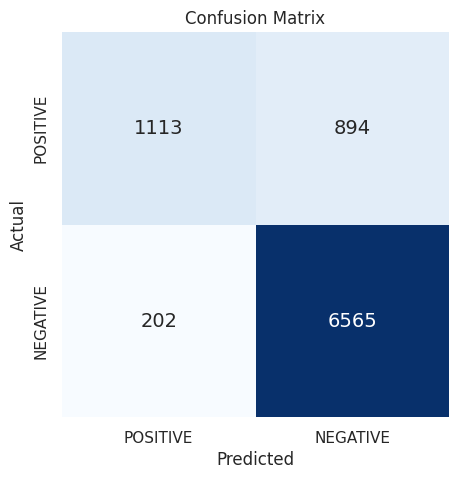

In [188]:
# ploting confusion matrix for Train dataset
plot_confusion_matrix(confusion_train, df['review_sentiment'].unique().tolist())

In [189]:
#Confusion matrix for Test Dataset
confusion_test =metrics.confusion_matrix(y_test, y_pred_class)
print(confusion_test)

[[ 236  283]
 [  50 1625]]


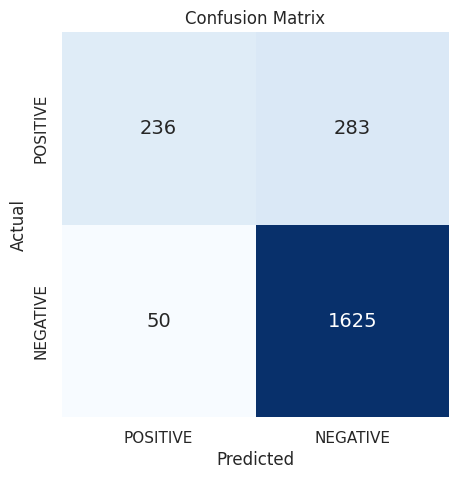

In [190]:
plot_confusion_matrix(confusion_test, df['review_sentiment'].unique().tolist())

In [191]:
#Sensitivity, Specificity, Precision, Recall for Train dataset
TN_train = confusion_train[0, 0]
FP_train = confusion_train[0, 1]
FN_train = confusion_train[1, 0]
TP_train = confusion_train[1, 1]

In [192]:
sensitivity_train = TP_train / float(FN_train + TP_train)
specificity_train = TN_train / float(TN_train + FP_train)
precision_train = TP_train / float(TP_train + FP_train)
print("sensitivity on train dataset",sensitivity_train)
print("specificity on train dataset",specificity_train)
print("precision on train dataset",precision_train)
print("RECALL SCORE on train dataset :", metrics.recall_score(y_train, y_pred_train))

sensitivity on train dataset 0.9701492537313433
specificity on train dataset 0.554559043348281
precision on train dataset 0.8801447915270143
RECALL SCORE on train dataset : 0.9701492537313433


In [193]:
#Sensitivity, Specificity, Precision, Recall for test datset
TN_test = confusion_test[0, 0]
FP_test = confusion_test[0, 1]
FN_test = confusion_test[1, 0]
TP_test = confusion_test[1, 1]

In [194]:
sensitivity_test = TP_test / float(FN_test + TP_test)
specificity_test = TN_test / float(TN_test + FP_test)
precision_test = TP_test / float(TP_test + FP_test)
print("sensitivity on test dataset",sensitivity_test)
print("specificity on train dataset",specificity_test)
print("precision on test dataset",precision_test)
print("RECALL SCORE on test dataset :", metrics.recall_score(y_test, y_pred_class))

sensitivity on test dataset 0.9701492537313433
specificity on train dataset 0.45472061657032753
precision on test dataset 0.8516771488469602
RECALL SCORE on test dataset : 0.9701492537313433


In [195]:
#F1 SCORE
print("F1 SCORE for train dataset :",metrics.f1_score(y_train, y_pred_train))
print("F1 SCORE for test dataset :",metrics.f1_score(y_test, y_pred_class))

F1 SCORE for train dataset : 0.9229579642907353
F1 SCORE for test dataset : 0.907061121964834


### **Plotting ROC Curve**

In [196]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

    return None

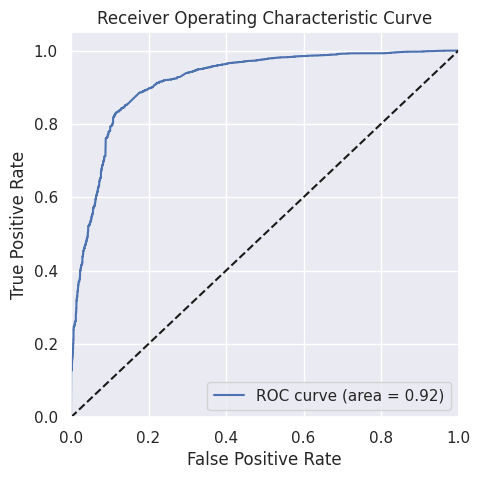

In [197]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob_tr[:,1], drop_intermediate = False)
draw_roc(y_train, y_pred_prob_tr[:,1])

In [198]:
def predict_sentiment(input_text):
    # Preprocess the input text (clean and preprocess similar to your training data)
    cleaned_text = preprocessText(input_text)

    # Vectorize the cleaned text using the fitted CountVectorizer
    input_vector = vect.transform([cleaned_text])

    # Make a prediction using the trained MNB model
    predicted_class = mnb.predict(input_vector)[0]

    # Return the predicted class
    return predicted_class

In [199]:
input_review = "This product is great! I love it."
predicted_sentiment = predict_sentiment(input_review)
print(predicted_sentiment)

1


In [200]:
input_review = "Bad quality. Charge does not last."
predicted_sentiment = predict_sentiment(input_review)
print(predicted_sentiment)

0


In [201]:
df.shape

(10968, 19)